# Gold vs. NIFTY 50 (TR)

Combines data from the FRED and NSE to study gold and NIFTY 50 TR returns.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)

fred<-Fred()
indices<-Indices()

## Gold
first, lets check what kind of data is available on the FRED for gold

In [2]:
goldFred <- fred$Meta() %>% 
    inner_join(fred$TimeSeries(), by = 'SERIES_ID') %>%
    filter(NAME %like% '%gold%') %>%
    group_by(SERIES_ID, TICKER, NAME) %>%
    summarize(MIN_TS = min(TIME_STAMP), MAX_TS = max(TIME_STAMP)) %>%
    select(SERIES_ID, TICKER, NAME, MIN_TS, MAX_TS) %>%
    collect()

goldFred %>% print()

# A tibble: 9 x 5
# Groups:   SERIES_ID, TICKER [9]
   SERIES_ID TICKER      NAME                                   MIN_TS   MAX_TS 
*      <int> <chr>       <chr>                                  <chr>    <chr>  
1    -2.15e9 GOLDAMGBD2… Gold Fixing Price 10:30 A.M. (London … 1968-04… 2019-0…
2    -2.15e9 GOLDAMGBD2… Gold Fixing Price 10:30 A.M. (London … 1968-04… 2019-0…
3    -2.15e9 GOLDAMGBD2… Gold Fixing Price 10:30 A.M. (London … 1999-01… 2019-0…
4    -2.15e9 GOLDPMGBD2… Gold Fixing Price 3:00 P.M. (London t… 1968-04… 2019-0…
5    -2.15e9 GOLDPMGBD2… Gold Fixing Price 3:00 P.M. (London t… 1968-04… 2019-0…
6    -2.15e9 GOLDPMGBD2… Gold Fixing Price 3:00 P.M. (London t… 1999-01… 2019-0…
7    -2.15e9 GVZCLS      CBOE Gold ETF Volatility Index         2008-06… 2019-0…
8    -2.15e9 VXGDXCLS    CBOE Gold Miners ETF Volatility Index  2011-03… 2019-0…
9    -2.15e9 VXGSCLS     CBOE Equity VIX on Goldman Sachs       2010-06… 2019-0…


In [3]:
seriesIdGold <- -2147252004 #use the afternoon USD fix
goldDf <- fred$TimeSeries() %>% 
    filter(SERIES_ID == seriesIdGold, TIME_STAMP >= as.Date('1995-01-01')) %>% 
    select(TIME_STAMP, VAL) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

fredDetailsGold <- goldFred %>% 
    filter(SERIES_ID == seriesIdGold)

print(nrow(goldDf))
print(head(goldDf))

goldXts <- xts(goldDf$VAL, goldDf$TIME_STAMP)

[1] 6194
# A tibble: 6 x 2
  TIME_STAMP   VAL
  <date>     <dbl>
1 1995-01-03  381.
2 1995-01-04  376.
3 1995-01-05  375.
4 1995-01-06  375.
5 1995-01-09  372.
6 1995-01-10  374.


### plot the price of gold in USD

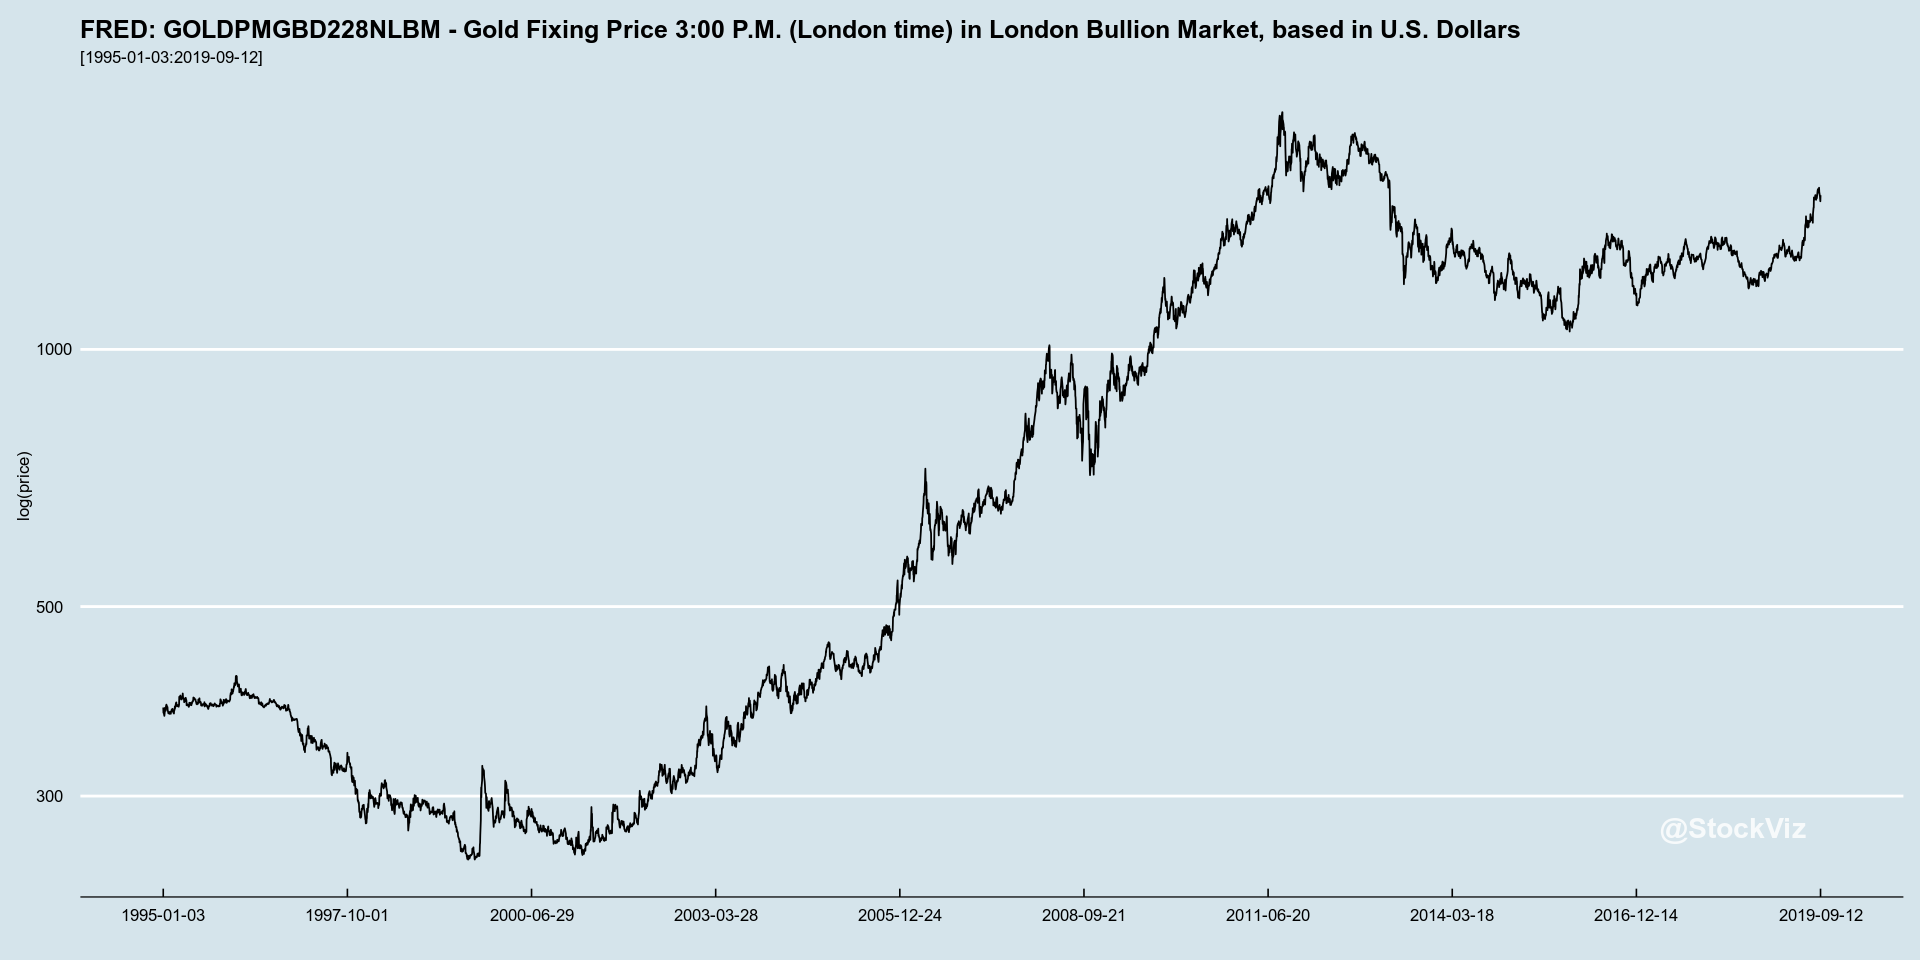

In [4]:
firstDate <- min(goldDf$TIME_STAMP)
lastDate <- max(goldDf$TIME_STAMP)
xAxisTicks <- seq(from=firstDate, to=lastDate, length.out=10)

options(repr.plot.width=16, repr.plot.height=8)

ggplot(goldDf, aes(x=TIME_STAMP, y=VAL)) +
    theme_economist() +
    #theme(text = element_text(size = 3), element_line(size = 0.1)) +
    geom_line() +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(price)', color='', title=sprintf("FRED: %s - %s", fredDetailsGold$TICKER[1], fredDetailsGold$NAME[1]), 
         subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
    annotate("text", x=lastDate, y=min(goldDf$VAL, na.rm=T), label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

## NIFTY 50

The NIFTY 50 TR index has been around since 1999. Translate that index to USD and plot monthly returns vs. gold.

In [5]:
trIndex <- indices$NseTimeSeries() %>%
    filter(NAME == "NIFTY 50 TR" && TIME_STAMP >= '2000-01-01' && TIME_STAMP <= lastDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

trXts <- xts(trIndex$CLOSE, trIndex$TIME_STAMP)

## USDINR

In [6]:
#DEXINUS, from the example: http://pluto.studio/user/shyams80/notebooks/docs-R/Fred.ipynb
seriesIdUsdInr <- -2147478748
usdInrDf <- fred$TimeSeries() %>% 
    filter(SERIES_ID == seriesIdUsdInr, TIME_STAMP >= as.Date('2000-01-01')) %>% 
    select(TIME_STAMP, VAL) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

fredDetailsUsdInr <- fred$Meta() %>% 
    filter(SERIES_ID == seriesIdUsdInr)

print(nrow(usdInrDf))
print(head(usdInrDf))

usdInrXts <- xts(usdInrDf$VAL, usdInrDf$TIME_STAMP)

[1] 4940
# A tibble: 6 x 2
  TIME_STAMP   VAL
  <date>     <dbl>
1 2000-01-03  43.6
2 2000-01-04  43.6
3 2000-01-05  43.6
4 2000-01-06  43.6
5 2000-01-07  43.6
6 2000-01-10  43.6


## Merge, compute and plot returns

In [7]:
allXts <- merge(trXts, usdInrXts, goldXts)
#holidays don't match up, so carry the USDINR forward.
allXts[,2] <- na.locf(allXts[,2])
allXts <- na.omit(allXts)

In [8]:
#end-of months don't match, so force them to a common on
monthlies <- merge(Common.NormalizeMonthlyDates(monthlyReturn(allXts[,1]/allXts[,2])), 
                   Common.NormalizeMonthlyDates(monthlyReturn(allXts[,3])))
names(monthlies) <-c('TR', 'GOLD')

print(head(monthlies))

                    TR         GOLD
2000-01-20 -0.05860819  0.006394316
2000-02-20  0.07061830  0.036533710
2000-03-20 -0.07516591 -0.057551507
2000-04-20 -0.07564460 -0.006142728
2000-05-20 -0.03917153 -0.010179967
2000-06-20  0.06566360  0.058402204


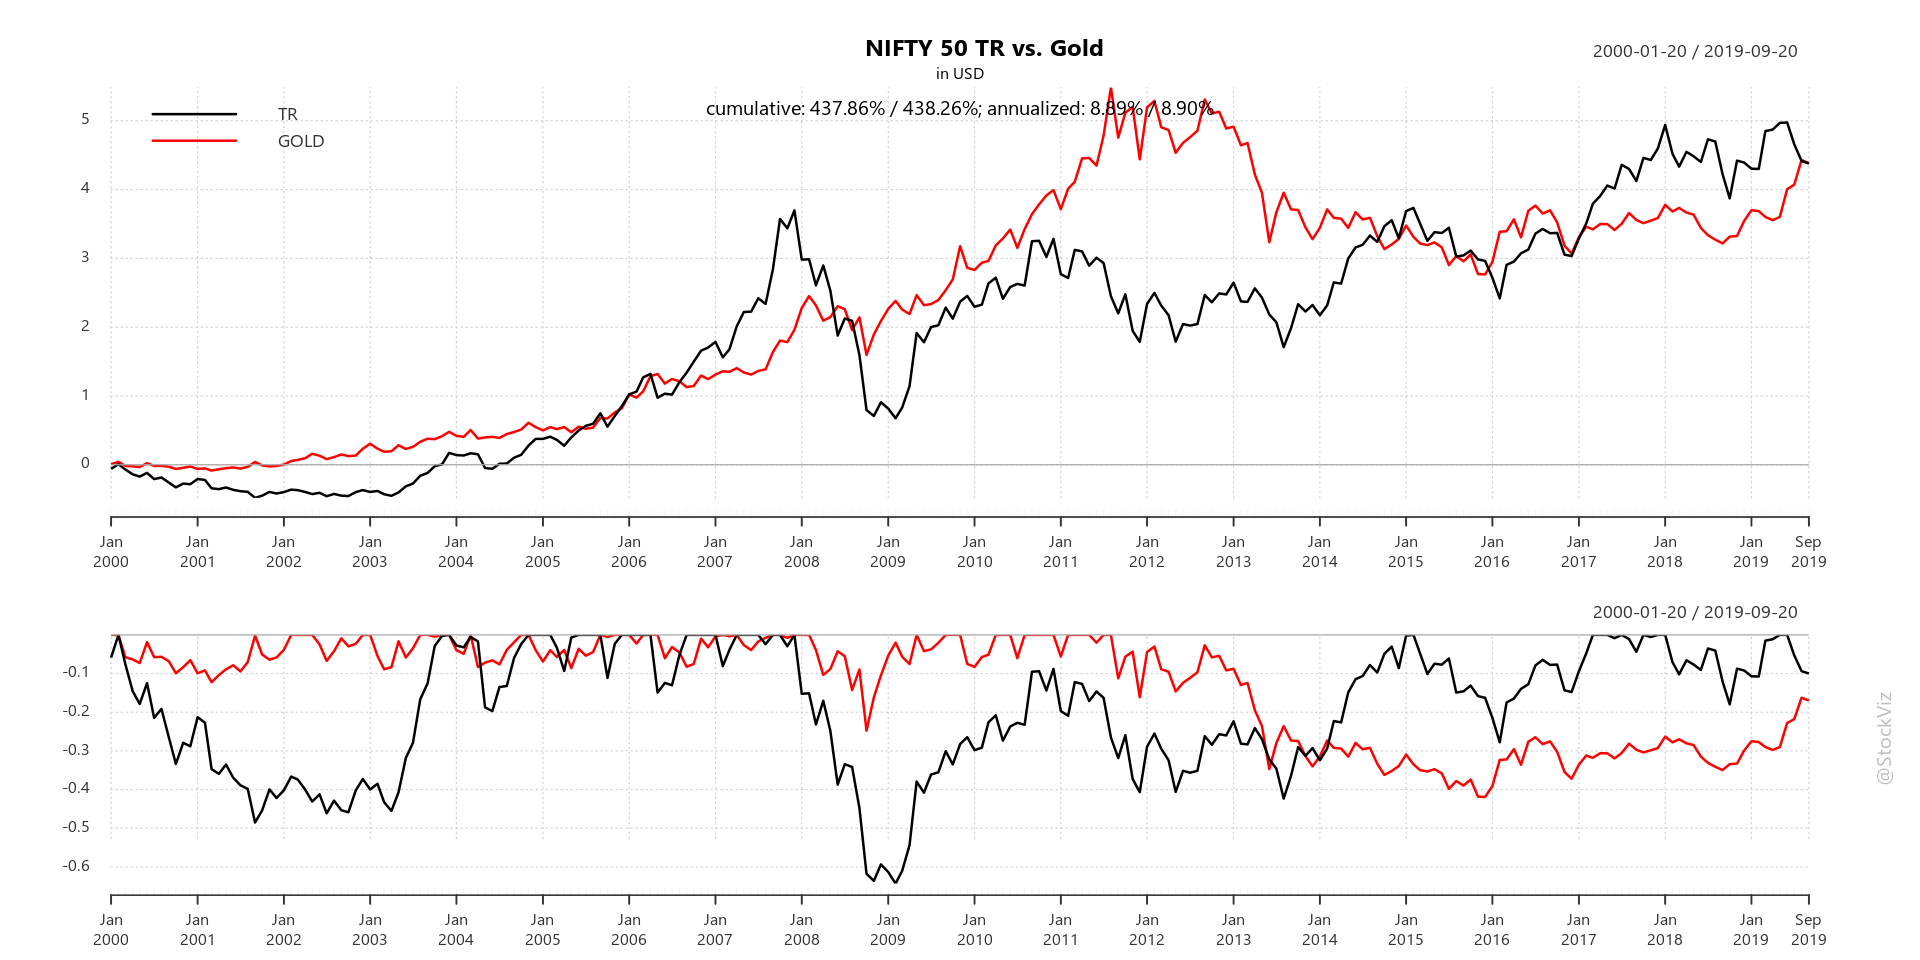

In [9]:
Common.PlotCumReturns(monthlies, "NIFTY 50 TR vs. Gold", "in USD")

## Take-away

NIFTY 50 has  point over gold in annualized returns. Better yet, the asset classes seem to be uncorrelated so they diversify each other.

For people with a time horizon of 8+ years, the RBI issued sovereign gold bonds are a good option. 

Related: https://stockviz.biz/2016/12/02/investing-in-gold/

*This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)*